<a href="https://colab.research.google.com/github/nvakiet/SparkML-Regression_And_Classification/blob/main/SparkML_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Group ID: **05 - KKAP**  
- Student name: **Ngo Van Anh Kiet**  
- Student ID: **19127191**

# Install Spark on Google Colab

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

!tar xf spark-3.2.1-bin-hadoop3.2.tgz

!pip install -q findspark

# Download the "Predict Future Sales" dataset from Kaggle

In [2]:
# Install Kaggle python package and create directory for kaggle credential
!pip install kaggle
!mkdir ~/.kaggle
# Copy the Kaggle credential to runtime machine (remember to mount the Google Drive containing the credential file)
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

# Download the dataset and unzip
!kaggle competitions download -c competitive-data-science-predict-future-sales
!unzip competitive-data-science-predict-future-sales.zip


 60% 9.00M/15.1M [00:00<00:00, 36.1MB/s]
100% 15.1M/15.1M [00:00<00:00, 50.6MB/s]
Archive:  competitive-data-science-predict-future-sales.zip
  inflating: item_categories.csv     
  inflating: items.csv               
  inflating: sales_train.csv         
  inflating: sample_submission.csv   
  inflating: shops.csv               
  inflating: test.csv                


# Import packages and initialize a Spark session

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# Import Spark libraries
import findspark
findspark.init()

In [74]:
from pyspark.sql import functions as f
from pyspark.sql import SparkSession, Window
from pyspark.ml.feature import *
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
from pyspark.ml.functions import vector_to_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
spark = (SparkSession
        .builder
        .appName('Lab 3 - SparkML: Regression')
        .getOrCreate()
)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", True)

# Load train and test datasets into Pyspark

In [6]:
data = spark.read.csv("sales_train.csv", header = True, inferSchema = True)
test = spark.read.csv("test.csv", header=True, inferSchema=True)

# Raw data overview
Firstly, let's see what the raw data looks like.

In [ ]:
# Print the dataframe schema
print("Training data schema")
data.printSchema()
print("Test data schema")
test.printSchema()

Training data schema
root
 |-- date: string (nullable = true)
 |-- date_block_num: integer (nullable = true)
 |-- shop_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- item_price: double (nullable = true)
 |-- item_cnt_day: double (nullable = true)

Test data schema
root
 |-- ID: integer (nullable = true)
 |-- shop_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)



In [ ]:
# See the first 10 samples
data.show(10)

+----------+--------------+-------+-------+----------+------------+
|      date|date_block_num|shop_id|item_id|item_price|item_cnt_day|
+----------+--------------+-------+-------+----------+------------+
|02.01.2013|             0|     59|  22154|     999.0|         1.0|
|03.01.2013|             0|     25|   2552|     899.0|         1.0|
|05.01.2013|             0|     25|   2552|     899.0|        -1.0|
|06.01.2013|             0|     25|   2554|   1709.05|         1.0|
|15.01.2013|             0|     25|   2555|    1099.0|         1.0|
|10.01.2013|             0|     25|   2564|     349.0|         1.0|
|02.01.2013|             0|     25|   2565|     549.0|         1.0|
|04.01.2013|             0|     25|   2572|     239.0|         1.0|
|11.01.2013|             0|     25|   2572|     299.0|         1.0|
|03.01.2013|             0|     25|   2573|     299.0|         3.0|
+----------+--------------+-------+-------+----------+------------+
only showing top 10 rows



Let's generate a summary of the whole dataframe to have a better understanding of the problem

In [ ]:
print("Column number:", len(data.columns))
print("Raw data summary:")
data.summary().show()

Column number: 6
Raw data summary:
+-------+----------+-----------------+------------------+------------------+------------------+-----------------+
|summary|      date|   date_block_num|           shop_id|           item_id|        item_price|     item_cnt_day|
+-------+----------+-----------------+------------------+------------------+------------------+-----------------+
|  count|   2935849|          2935849|           2935849|           2935849|           2935849|          2935849|
|   mean|      null|14.56991146343017|33.001728290521754|10197.227056977385| 890.8532326980396|1.242640885140891|
| stddev|      null|9.422987708755963| 16.22697304833343|6324.2973538912065|1729.7996307126489|2.618834430895435|
|    min|01.01.2013|                0|                 0|                 0|              -1.0|            -22.0|
|    25%|      null|                7|                22|              4476|             249.0|              1.0|
|    50%|      null|               14|               

From the summary, we can see the dataset has a shape of (2935849,6). This is a time series where the sales count not only depends on the price but also depends on the dates. There's also the fact that the problem requires us to predict the sales count by month while this dataset is indexed by date, so some aggregation must be done on this dataframe.  
Judging from the summary (mean, std, min, max) of item_price and item_cnt_day, there're definitely outliers in the data, and maybe some missing values.  
Because the basic Spark MLlib library doesn't have any class for time series modeling, we must perform some feature engineering to convert this dataset from a time series forecasting problem to a regression problem so we can fit it with SparkML's regressors.

# Data preprocessing
To prevent data leakage problem, we remove any item in training set which doesn't exist in test set. With Spark, this can be done by doing a semi join.

In [7]:
# Perform semi join
train = (data.join(test, ["shop_id", "item_id"], "semi")
              .select(data.columns))
# See if the number of rows decreases
print("Rows after joining:", train.count())
print("Summary:")
train.summary().show()

Rows after joining: 1224439
Summary:
+-------+----------+------------------+------------------+------------------+------------------+-----------------+
|summary|      date|    date_block_num|           shop_id|           item_id|        item_price|     item_cnt_day|
+-------+----------+------------------+------------------+------------------+------------------+-----------------+
|  count|   1224439|           1224439|           1224439|           1224439|           1224439|          1224439|
|   mean|      null|19.354722448402903| 32.15116637088495| 9614.865821817175|1030.6659907978053|1.321234459209483|
| stddev|      null|  9.11072237679056|16.465624442549235|6299.8703350761325|1827.3837613285657|3.312996878793288|
|    min|01.01.2013|                 0|                 2|                30|               0.5|            -16.0|
|    25%|      null|                12|                19|              4181|             299.0|              1.0|
|    50%|      null|                21|    

We can consider the negative item prices and counts as outliers and remove them beforehand to calculate the mean price and sales better.

In [8]:
train = train.where((train.item_price >= 0) & (train.item_cnt_day >= 0))
train.count()

1221498

Group the data by month block index, shop id and item id.  
Then perform aggregation to create new features based on each (month, shop, item) tuple.

In [9]:
train = (
    train.groupBy(["date_block_num", "shop_id", "item_id"]).agg(
        f.sum("item_price").alias("all_itemPrice_month"), # Sum of item prices by each item per month
        f.mean("item_price").alias("mean_itemPrice_month"), # Mean of item prices by each item per month
        f.sum("item_cnt_day").alias("item_cnt_month"), # Total item sold per month
        f.mean("item_cnt_day").alias("mean_itemCnt_month"), # Mean of item sold per month
        f.count("item_cnt_day").alias("days_sold_month") # Number of days the item is sold each month
    ).withColumnRenamed("date_block_num", "month_index")
)

In [ ]:
train.summary().show()

+-------+------------------+-----------------+-----------------+-------------------+--------------------+------------------+------------------+------------------+
|summary|       month_index|          shop_id|          item_id|all_itemPrice_month|mean_itemPrice_month|    item_cnt_month|mean_itemCnt_month|   days_sold_month|
+-------+------------------+-----------------+-----------------+-------------------+--------------------+------------------+------------------+------------------+
|  count|            599912|           599912|           599912|             599912|              599912|            599912|            599912|            599912|
|   mean|20.158761618370693|32.06313926042486|10015.36912747203|  2095.652567542916|   911.0195486812893| 2.701724586272653|1.0957363340076394|2.0361286321993894|
| stddev| 9.139259988979074|16.88954154941829| 6192.91195449407|  6988.195273079581|  1563.8147208759856|11.292583509624817| 1.765562879428182|2.3191656679151755|
|    min|             

From the summary, there are definitely outliers in all_itemPrice_month and item_cnt_month since their max values are so far away from the mean values. Let's make some boxplots to check for outliers in these 2 features. Since the data is in a Spark dataframe, we will select the features into 2 Spark RDDs then map the values to a list so they can be indexed by matplotlib.  
Since the dataset is small enough to fit into Google Colab runtime memory, we can use the whole data. But if the data size gets too large, we should take random samples with a sampling ratio of 10% (0.1), or 1000 samples.

In [10]:
# Map the 2 features into 2 lists (use a seed of 19127191 to keep the sample results across different runs)
sampling_ratio = 1 # Change this if the data size is too large
itemPrices = train.select("all_itemPrice_month").rdd.map(lambda row: row.all_itemPrice_month).sample(False, sampling_ratio, 19127191).collect()
itemCounts = train.select("item_cnt_month").rdd.map(lambda row: row.item_cnt_month).sample(False, sampling_ratio, 19127191).collect()

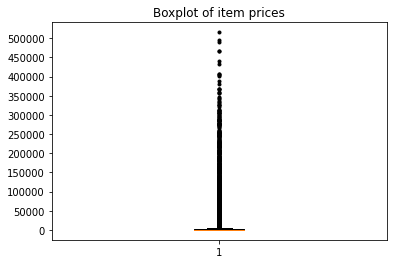

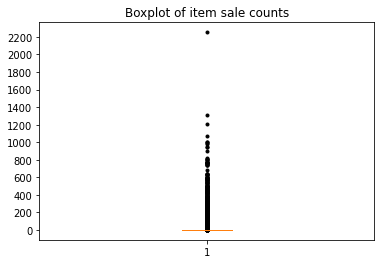

In [ ]:
# Draw boxplots of the 2 features to check for outliers
# Item prices
plt.boxplot(itemPrices, sym='k.')
plt.yticks(np.arange(0, 550000, 50000))
plt.title("Boxplot of item prices")
plt.show()

print()
# Item sales
plt.boxplot(itemCounts, sym='k.')
plt.yticks(np.arange(0, 2400, 200))
plt.title("Boxplot of item sale counts")
plt.show()

From the boxplots, we can treat any price sum > 400000 or monthly sale count > 800 as outliers

In [11]:
train = train.where((train.all_itemPrice_month <= 400000) & (train.item_cnt_month <= 800))
train.count()

599887

Generate all posible combinations of month indices, shop ids and item ids. This is for later when we create lag features from time series, an item maybe available at a certain month, but not all months before that, which will make it impossible to create lag features for that item. So we need these combinations to fill in the missing records.

In [12]:
combinations = (
    (train.select("month_index").distinct()).crossJoin(
        train.select("shop_id").distinct())
    ).crossJoin(
        train.select("item_id").distinct()
    )

To fill the missing records with these combinations, simply do a right outer join. Then fill the missing values with 0.

In [13]:
train_monthly = train.join(combinations, ["month_index", "shop_id", "item_id"], "rightouter")
train_monthly = train_monthly.fillna(0)

# Perform a sort operation to keep the time series order
train_monthly = train_monthly.orderBy(["month_index", "shop_id", "item_id"], ascending=[1,1,1])

Now let's see what our new dataset looks like

In [ ]:
print("10 first samples:")
train_monthly.show(10)
print("Summary:")
train_monthly.summary().show()

10 first samples:
+-----------+-------+-------+-------------------+--------------------+--------------+------------------+---------------+
|month_index|shop_id|item_id|all_itemPrice_month|mean_itemPrice_month|item_cnt_month|mean_itemCnt_month|days_sold_month|
+-----------+-------+-------+-------------------+--------------------+--------------+------------------+---------------+
|          0|      2|     30|                0.0|                 0.0|           0.0|               0.0|              0|
|          0|      2|     31|                0.0|                 0.0|           0.0|               0.0|              0|
|          0|      2|     32|                0.0|                 0.0|           0.0|               0.0|              0|
|          0|      2|     33|              499.0|               499.0|           1.0|               1.0|              1|
|          0|      2|     38|                0.0|                 0.0|           0.0|               0.0|              0|
|          0| 

# Exploratory Data Analysis (EDA)  
Add columns for the date and month of each sale records, we'll use this to analyze the sale trend of the time series.

In [14]:
train_monthly = (
    train_monthly.withColumn("month", train_monthly.month_index % 12)
                 .withColumn("year", (train_monthly.month_index / 12).cast("int") + 2013)
)
train_monthly.columns

['month_index',
 'shop_id',
 'item_id',
 'all_itemPrice_month',
 'mean_itemPrice_month',
 'item_cnt_month',
 'mean_itemCnt_month',
 'days_sold_month',
 'month',
 'year']

Calculate the mean and sum of sales for each month label. Then plot them on a line plot to see how the sales trend and seasonality over the years.

In [15]:
# Perform aggregation
month_index_means = train_monthly.groupBy("month_index").agg(f.mean("item_cnt_month").alias("month_index_mean")).orderBy("month_index")
month_means = train_monthly.groupBy("month").agg(f.mean("item_cnt_month").alias("month_mean")).orderBy("month")

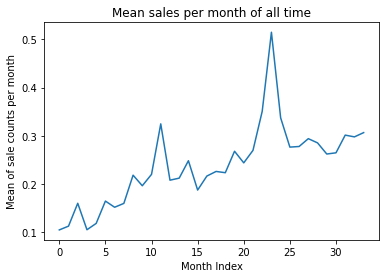

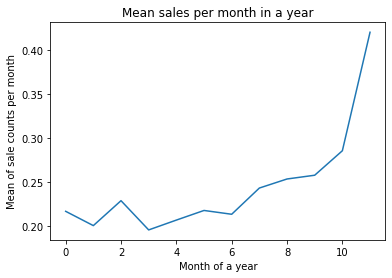

In [16]:
# Convert the data to a list using Spark RDD then plot it with mathplotlib
months = range(12)
month_indices = range(34)
lMonthMean = month_means.rdd.map(lambda row: row.month_mean).collect()
lMonthIdxMean = month_index_means.rdd.map(lambda row: row.month_index_mean).collect()

# Plot the lines
plt.plot(month_indices, lMonthIdxMean)
plt.xlabel("Month Index")
plt.ylabel("Mean of sale counts per month")
plt.title("Mean sales per month of all time")
plt.show()
print()
plt.plot(months, lMonthMean)
plt.xlabel("Month of a year")
plt.ylabel("Mean of sale counts per month")
plt.title("Mean sales per month in a year")
plt.show()

As we can see from the first figure, there's a certain trend where the overall sales count gradually goes up over the years. There're also some patterns (seasonality) in the data where the sales count spikes up a lot toward the end of each year and some small spikes every 3 months.  
We must take these trend and seasonality into account during the feature engineering process.

# Feature engineering  
After performing pre-processing and analysis, we will start converting the time series data to regression data. First of all, let's create the prediction column for our data.  
Originally, this dataset uses item_cnt_month for the target column. However, as a time series, what we aim to predict is the sales value for the next month. To convert this problem to a regression problem, we add a column that says "sales prediction for next month" using the sales in the row following the current row. This will be our target column.

In [18]:
# Create windows for constructing lag features and rolling-window features
window = Window.orderBy("month_index").partitionBy(["shop_id", "item_id"])
rolling_window = Window.orderBy("month_index").partitionBy(["shop_id", "item_id"]).rangeBetween(-2, 0) # rolling window with size 3

In [19]:
# Use the select() function to add columns to the dataframe
# Then use the lag() function to shift the item_cnt_month column upward (next row value is shifted to current row)
train_monthly = train_monthly.select(
    "*",
    f.lag("item_cnt_month", offset=-1, default=0).over(window).alias("itemCnt_nextMonth")
)

Next, let's create some lag-based features. Since we are concerned with the trend-cycle of the time series, we will calculate the moving average trend using the current month and the last 2 months (lag-1, lag-2), then detrend the item_cnt_month by subtracting the moving average trend from said column, the detrended item_cnt_month can be a feature for our models to learn.

In [20]:
# Create lag-1 and lag-2
train_monthly = train_monthly.select(
    "*",
    f.lag("item_cnt_month", offset=1, default=0).over(window).alias("itemCnt_lag_1"),
    f.lag("item_cnt_month", offset=2, default=0).over(window).alias("itemCnt_lag_2")
)

In [21]:
# Create the itemCnt_trendCycle feature
train_monthly = train_monthly.withColumn(
    "itemCnt_trendCycle",
    (train_monthly.item_cnt_month - train_monthly.itemCnt_lag_1 - train_monthly.itemCnt_lag_2) / 3
)

Now we add some rolling-window features of the item_cnt_month. We'll use min, max, mean, standard deviation of item_cnt_month over 3 months: current and last 2 months.

In [22]:
train_monthly = (train_monthly.withColumn("item_cnt_min", f.min("item_cnt_month").over(rolling_window))
                              .withColumn("item_cnt_max", f.max("item_cnt_month").over(rolling_window))
                              .withColumn("item_cnt_mean", f.mean("item_cnt_month").over(rolling_window))
                              .withColumn("item_cnt_std", f.stddev("item_cnt_month").over(rolling_window))
)

In [23]:
# Fill in the missing values from the new features
train_monthly = train_monthly.fillna(0)

Now let's see our dataset summary after feature engineering.

In [ ]:
print("First 10 samples:")
train_monthly.show(10)
print("Summary:")
train_monthly.summary().show()

First 10 samples:
+-----------+-------+-------+-------------------+--------------------+--------------+------------------+---------------+-----+----+-----------------+-------------+-------------+-------------------+------------+------------+------------------+------------------+
|month_index|shop_id|item_id|all_itemPrice_month|mean_itemPrice_month|item_cnt_month|mean_itemCnt_month|days_sold_month|month|year|itemCnt_nextMonth|itemCnt_lag_1|itemCnt_lag_2| itemCnt_trendCycle|item_cnt_min|item_cnt_max|     item_cnt_mean|      item_cnt_std|
+-----------+-------+-------+-------------------+--------------------+--------------+------------------+---------------+-----+----+-----------------+-------------+-------------+-------------------+------------+------------+------------------+------------------+
|          0|      2|     31|                0.0|                 0.0|           0.0|               0.0|              0|    0|2013|              4.0|          0.0|          0.0|                0.0

# Train-Validation Split  
We will use the final month (33) as our test set since we want to use it for predicting the target month. 9 months before that (24-32) will be used for validation and the rest except for first 2 months (2-23) will be used for training.

In [103]:
# Split the dataframe into 3 sets
train_set = train_monthly.where("month_index > 1 and month_index < 24")
validation_set = train_monthly.where("month_index >= 24 and month_index < 33")
test_set = train_monthly.where("month_index == 33")

# Drop rows with null values
train_set = train_set.dropna()
validation_set = validation_set.dropna()

# Print number of records in each set
# print('Train set records:', train_set.count())
# print('Validation set records:', validation_set.count())
# print('Test set records:', test_set.count())

Let's perform mean encoding to convert categorical features like shop_id, item_id, month, year to continuous features with respect to the target column. This must be done after splitting train/validation dataset to avoid data leakage (model will know about validation data while training).

In [104]:
# Aggregate the mean encoding of categorical features
shop_mean = train_set.groupBy("shop_id").agg(f.mean("itemCnt_nextMonth").alias("shop_mean"))
item_mean = train_set.groupBy("item_id").agg(f.mean("itemCnt_nextMonth").alias("item_mean"))
year_mean = train_set.groupBy("year").agg(f.mean("itemCnt_nextMonth").alias("year_mean"))
month_mean = train_set.groupBy("month").agg(f.mean("itemCnt_nextMonth").alias("month_mean"))

In [105]:
# Add the mean encoding feature derived from training set to all sets
# Training set
train_set = train_set.join(shop_mean, ["shop_id"], "left")
train_set = train_set.join(item_mean, ["item_id"], "left")
train_set = train_set.join(year_mean, ["year"], "left")
train_set = train_set.join(month_mean, ["month"], "left")
train_set = train_set.withColumn("itemCnt_nextMonth", f.col("itemCnt_nextMonth").cast("int"))
train_set = train_set.drop("month_index") # Drop this column since we already have mean encoding of months and years

# Validation set
validation_set = validation_set.join(shop_mean, ["shop_id"], "left")
validation_set = validation_set.join(item_mean, ["item_id"], "left")
validation_set = validation_set.join(year_mean, ["year"], "left")
validation_set = validation_set.join(month_mean, ["month"], "left")
validation_set = validation_set.withColumn("itemCnt_nextMonth", f.col("itemCnt_nextMonth").cast("int"))
validation_set = validation_set.drop("month_index")

# Test set
test_set = test_set.join(shop_mean, ["shop_id"], "left")
test_set = test_set.join(item_mean, ["item_id"], "left")
test_set = test_set.join(year_mean, ["year"], "left")
test_set = test_set.join(month_mean, ["month"], "left")
test_set = test_set.withColumn("itemCnt_nextMonth", f.col("itemCnt_nextMonth").cast("int"))
test_set = test_set.drop("itemCnt_nextMonth")
test_set = test_set.drop("month_index")
# Add products which never exist in the training data during the record combination generation phase but is in the testing data
test_columns = test_set.columns
test_set = test.join(test_set, on=["shop_id", "item_id"], how="left")

# Reorder columns from all 3 sets to match each other
train_set = train_set.select(sorted(train_set.columns))
validation_set = validation_set.select(sorted(train_set.columns))
test_set = test_set.select(sorted(test_columns))

# Fill all null values with 0
train_set = train_set.fillna(0)
validation_set = validation_set.fillna(0)
test_set = test_set.fillna(0)

Check the schema of training, validation and test set.

In [106]:
train_set.printSchema()
validation_set.printSchema()
test_set.printSchema()

root
 |-- all_itemPrice_month: double (nullable = false)
 |-- days_sold_month: long (nullable = true)
 |-- itemCnt_lag_1: double (nullable = false)
 |-- itemCnt_lag_2: double (nullable = false)
 |-- itemCnt_nextMonth: integer (nullable = true)
 |-- itemCnt_trendCycle: double (nullable = false)
 |-- item_cnt_max: double (nullable = false)
 |-- item_cnt_mean: double (nullable = false)
 |-- item_cnt_min: double (nullable = false)
 |-- item_cnt_month: double (nullable = false)
 |-- item_cnt_std: double (nullable = false)
 |-- item_id: integer (nullable = true)
 |-- item_mean: double (nullable = false)
 |-- mean_itemCnt_month: double (nullable = false)
 |-- mean_itemPrice_month: double (nullable = false)
 |-- month: integer (nullable = true)
 |-- month_mean: double (nullable = false)
 |-- shop_id: integer (nullable = true)
 |-- shop_mean: double (nullable = false)
 |-- year: integer (nullable = true)
 |-- year_mean: double (nullable = false)

root
 |-- all_itemPrice_month: double (nullable 

Finally, we restructure the dataframes using VectorAssembler so they can be used with Spark ML models.

In [107]:
# Restructure training set
inputColumns = train_set.drop("itemCnt_nextMonth").columns
assembler1 = VectorAssembler(inputCols=inputColumns, outputCol="features")
train_assembled = assembler1.transform(train_set).select(["features", "itemCnt_nextMonth"])

# Restructure validation set
inputColumns = validation_set.drop("itemCnt_nextMonth").columns
assembler2 = VectorAssembler(inputCols=inputColumns, outputCol="features")
validation_assembled = assembler2.transform(validation_set).select(["features", "itemCnt_nextMonth"])

# Restructure test set
inputColumns = test_set.columns
assembler3 = VectorAssembler(inputCols=inputColumns, outputCol="features")
test_assembled = assembler3.transform(test_set).select(["features"])

In [108]:
# Check the schema again
train_assembled.printSchema()
validation_assembled.printSchema()
test_assembled.printSchema()

root
 |-- features: vector (nullable = true)
 |-- itemCnt_nextMonth: integer (nullable = true)

root
 |-- features: vector (nullable = true)
 |-- itemCnt_nextMonth: integer (nullable = true)

root
 |-- features: vector (nullable = true)



We will also get the min, max prediction values from training set and validation set to normalize the RMSE of our models later on.

In [43]:
train_maxVal = train_set.groupby().max('itemCnt_nextMonth').collect()[0].asDict()['max(itemCnt_nextMonth)']
train_minVal = train_set.groupby().min('itemCnt_nextMonth').collect()[0].asDict()['min(itemCnt_nextMonth)']
validation_maxVal = validation_set.groupby().max('itemCnt_nextMonth').collect()[0].asDict()['max(itemCnt_nextMonth)']
validation_minVal = validation_set.groupby().min('itemCnt_nextMonth').collect()[0].asDict()['min(itemCnt_nextMonth)']

# Modeling data  
Now we can use machine learning models to perform regression on the processed data.

### Linear Regression  
Firstly, we must rescale/normalize the features. This is a necessary step for linear regression.

In [52]:
# Rescale training set
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(train_assembled)
train_scaled = scaler_model.transform(train_assembled).select(["scaledFeatures", "itemCnt_nextMonth"])

# Rescale validation set
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(validation_assembled)
validation_scaled = scaler_model.transform(validation_assembled).select(["scaledFeatures", "itemCnt_nextMonth"])

Before using Linear Regression, we should use a feature selector to reduce the data dimensionality, it'll reduce training time and reduce overfitting. Here we'll use Univariate Feature Selector to select the best 30% features from the training set. The selector will be fitted on the training set, then we will use it to transform both the training and validation set.

In [53]:
selector = UnivariateFeatureSelector(featuresCol="scaledFeatures", outputCol="selectedFeatures", labelCol="itemCnt_nextMonth", selectionMode="percentile")
selector.setFeatureType("continuous").setLabelType("continuous").setSelectionThreshold(0.3)
selector_model = selector.fit(train_scaled)
train_selected = selector_model.transform(train_scaled).select(["selectedFeatures", "itemCnt_nextMonth"])
validation_selected = selector_model.transform(validation_scaled).select(["selectedFeatures", "itemCnt_nextMonth"])

In [54]:
train_selected.head().selectedFeatures

DenseVector([0.1532, 2.1797, 2.2539, 3.0308, -3.592, 2.1551])

So 6 features have been selected from 20 features of the training set. We'll use the selected feature to train the linear regression model.

In [55]:
# Initialize the model with regularization parameter of 0.3, the balance between L2 and L1 regularization is 0.3
lr = LinearRegression(featuresCol="selectedFeatures", labelCol="itemCnt_nextMonth", regParam=0.3, elasticNetParam=0.3, maxIter=10)
lr_model = lr.fit(train_selected)

Print out the summary after training finishes

In [60]:
trainingSummary = lr_model.summary
print("Train RMSE:", trainingSummary.rootMeanSquaredError)
print("Train Adjusted R2:", trainingSummary.r2adj)

Train RMSE: 2.221969755625813
Train Adjusted R2: 0.5499202422130905


The Adjusted R2 value says that about 54.9% ~ 55% of the records in our training set can be used to explain the target records. This is because originally we filled our training set with a lot of empty records using the combinations of (month_index, shop_id, item_id). As long as the adjusted R2 value is over 50%, we can consider our model good enough for evaluation.  
To better understand the RMSE value, we normalize it against the result range of the training set (max and min of itemCnt_nextMonth). This will scale the RMSE to between 0 and 1. The closer it is to 0, the more our model fits, but if it's completely 0, that means the model is overfitting so we must be careful.

In [57]:
print("Normalized RMSE:", trainingSummary.rootMeanSquaredError / (train_maxVal - train_minVal))

Normalized RMSE: 0.002780938367491631


It looks like the normalized error on training set is quite small. That means our model is good enough. Now let's test it on validation set.

In [58]:
# Let the model predict the validation set
lr_predictions = lr_model.transform(validation_selected)

# Use a Regression Evaluator to evaluate the prediction results
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="itemCnt_nextMonth",metricName="rmse")
validation_rmse = lr_evaluator.evaluate(lr_predictions)
print("Validation RMSE:", validation_rmse)

Validation RMSE: 2.264954954079689


Again, let's normalized this error to have a better understanding of the evaluation.

In [59]:
print("Normalized validation RMSE:", validation_rmse / (validation_maxVal - validation_minVal))

Normalized validation RMSE: 0.003052499938112788


So we can see with the normalized RMSE being very close to 0, the linear regression model is well-fitted enough. Since the RMSE of validation set is slightly higher than training set, there may be some overfitting, but the difference is small enough.

### Random Forest Regression  
Unlike with Linear Regression, the Random Forest inherently can do feature selection so we just need to train it with all of our assembled features.

In [62]:
rf = RandomForestRegressor(featuresCol="features", labelCol="itemCnt_nextMonth", numTrees=50, maxDepth=7)
rf_model = rf.fit(train_assembled)

Because PySpark's random forest regressor can't give the training summary, we'll skip to the evaluation phase.

In [63]:
# Use the model to predict on validation set
rf_predictions = rf_model.transform(validation_assembled)

# Use a Regression Evaluator to evaluate the prediction results
rf_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="itemCnt_nextMonth",metricName="rmse")
rf_validation_rmse = rf_evaluator.evaluate(rf_predictions)
print("Validation RMSE:", rf_validation_rmse)
print("Normalized validation RMSE:", rf_validation_rmse / (validation_maxVal - validation_minVal))

Validation RMSE: 2.141026459429935
Normalized validation RMSE: 0.002885480403544387


We can see the validation RMSE and normalized RMSE of this model is smaller than the previous validation RMSE. It looks like the Random Forest Regressor model is better than Linear Regression model. Let's see how much importance the random forest model gives for each feature.

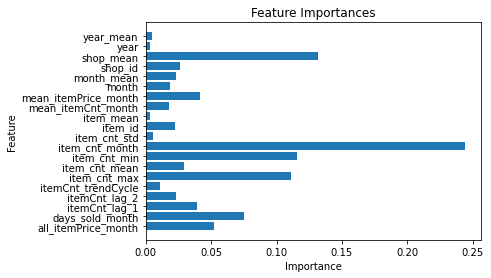

In [69]:
# Get the feature importance list from the random forest
importance = rf_model.featureImportances

# Draw a bar plot to see the features
inputColumns = train_set.columns.copy()
inputColumns.remove("itemCnt_nextMonth")
plt.barh(inputColumns, importance)
plt.title("Feature Importances")
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

The Random Forest model determines that the sales number of current month (item_cnt_month) is the most important feature, which is correct with how the time series works. The next 4 most important features are:  
- Mean encoding of shop id (shop_mean),  
- The rolling-window based features for min and max of item sales for 3 months (item_cnt_min, item_cnt_max),  
- The number of days in a month that a product is sold (days_sold_month).

# Make prediction on test set  
We'll use the trained model to make prediction for November 2015 sales on the test set, which is month index 33. The choosen model is Random Forest Regressor since it has better validation RMSE than the Linear Regression model.

In [109]:
# Make prediction
november_predictions = rf_model.transform(test_assembled)

In [110]:
# Get the shop_id, item_id and prediction result columns from the assembled test set
results = (november_predictions
    .withColumn("feature", vector_to_array("features"))
    .select([f.col("feature")[i] for i in [16, 10]] + ["prediction"])
    .withColumnRenamed("feature[16]", "shop_id")
    .withColumnRenamed("feature[10]", "item_id")
    .withColumnRenamed("prediction", "item_cnt_month")
    .withColumn("shop_id", f.col("shop_id").cast("int"))
    .withColumn("item_id", f.col("item_id").cast("int"))
)


In [97]:
results.show(10)

+-------+-------+-------------------+
|shop_id|item_id|     item_cnt_month|
+-------+-------+-------------------+
|     31|     30| 0.6351059674619476|
|     31|     31| 0.6522275828741929|
|     31|     38|  0.557441392982103|
|     31|     42| 0.0838327755421791|
|     31|     45| 1.1773823248676627|
|     31|     53|  0.965339869670807|
|     31|     57| 0.7223339267835465|
|     31|     59| 1.4343322358981883|
|     31|     62|  0.875229919058947|
|     31|     64|0.47995549983338526|
+-------+-------+-------------------+
only showing top 10 rows



In [113]:
# Join the original test dataset with the results set to get the tuple id column
submission = test.join(results, on=["shop_id", "item_id"], how="left").select(["ID", "item_cnt_month"]).orderBy("ID")

# Round the prediction to 2 decimal places
submission = submission.withColumn("item_cnt_month", f.round("item_cnt_month", 2))

In [114]:
submission.show(10)

+---+--------------+
| ID|item_cnt_month|
+---+--------------+
|  0|          0.82|
|  1|          0.03|
|  2|          1.09|
|  3|          0.31|
|  4|          0.03|
|  5|          0.61|
|  6|          1.17|
|  7|           0.1|
|  8|          1.05|
|  9|          0.04|
+---+--------------+
only showing top 10 rows



In [116]:
submission.count()

214200

The number of row is exactly like the sample submission file. Now that we have the prediction for next month, let's save it to a CSV file.

In [115]:
submission.write.csv("submission.csv")

Save our models for future uses

In [117]:
lr_model.save("linear_regression.model")
rf_model.save("random_forest_regression.model")

Zip the model folders to download from Google Colab

In [118]:
!zip -r /content/linear_regression_model.zip /content/linear_regression.model
!zip -r /content/random_forest_regression_model.zip /content/random_forest_regression.model

  adding: content/linear_regression.model/ (stored 0%)
  adding: content/linear_regression.model/data/ (stored 0%)
  adding: content/linear_regression.model/data/._SUCCESS.crc (stored 0%)
  adding: content/linear_regression.model/data/_SUCCESS (stored 0%)
  adding: content/linear_regression.model/data/part-00000-fb2f2ca4-023c-46c0-b99e-e49e72bed066-c000.snappy.parquet (deflated 53%)
  adding: content/linear_regression.model/data/.part-00000-fb2f2ca4-023c-46c0-b99e-e49e72bed066-c000.snappy.parquet.crc (stored 0%)
  adding: content/linear_regression.model/metadata/ (stored 0%)
  adding: content/linear_regression.model/metadata/part-00000 (deflated 43%)
  adding: content/linear_regression.model/metadata/._SUCCESS.crc (stored 0%)
  adding: content/linear_regression.model/metadata/_SUCCESS (stored 0%)
  adding: content/linear_regression.model/metadata/.part-00000.crc (stored 0%)
  adding: content/random_forest_regression.model/ (stored 0%)
  adding: content/random_forest_regression.model/tr

# Conclusion  
In conclusion, the Random Forest Regression model is better than the Linear Regression model. There're still many things that can be improved for better predictions, such as:  
- Using a stricter outlier range (of sales count and item prices),  
- Filling the missing data with mean or median of product over all months instead of just 0,  
- Engineering more lag-based features and rolling-window features,  
- Create an ensemble model using many different regression models,  
- Use statsmodel library to extract the more accurate trend and seasonality from the time series to use as features,
- Use a hyperparameter tuning algorithm, PySpark only supports K-Fold Cross Validation, which isn't suited for time series forecasting problems,  
- Use a recurrent neural network like LSTM instead of turning this dataset into a regression problem.  

Currently, the core SparkML framework doesn't have good supports for time series forecasting problems, we hope that in the future, Apache Spark and SparkML will have more tools for building machine learning models from time series data and even deep learning algorithms.

# References
1. https://www.kaggle.com/code/dimitreoliveira/model-stacking-feature-engineering-and-eda/notebook  
2. https://machinelearningmastery.com/time-series-forecasting-supervised-learning/  
3. https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/  
4. https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data  
5. https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/  
6. https://stackoverflow.com/questions/70582516/perform-lag-over-multiple-columns-using-pyspark  
7. https://www.coursera.org/lecture/ds/plotting-with-apachespark-and-pythons-matplotlib-mjCxm